# CNN/LSTM Model for Composer Classification

#### Daniel, Tyler and Rahul

In [ ]:
!pip install pretty_midi

In [ ]:
import os
import numpy as np
import pandas as pd
import pretty_midi
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import random
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CyclicLR, OneCycleLR
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from google.colab import drive
drive.mount('/content/drive')
# warnings.filterwarnings("ignore")

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Composer_Dataset/NN_midi_files_extended'

#### Data Loading and Preprocessing

- load_midi_file function: Loads a MIDI file and returns a PrettyMIDI object, logging any errors encountered.
- extract_advanced_features function: Extracts various musical features (such as pitch, rhythm, and dynamics) from a PrettyMIDI object.
- process_data function: Processes all MIDI files in the specified directory, extracting features from each file and storing them in a DataFrame.
- Data Encoding and Splitting: Encodes the composer labels and splits the dataset into training and testing sets, followed by feature scaling and conversion to PyTorch tensors.

In [ ]:
logging.basicConfig(filename='midi_processing.log', level=logging.WARNING)

def load_midi_file(file_path):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            midi_data = pretty_midi.PrettyMIDI(file_path)
        return midi_data
    except Exception as e:
        logging.warning(f"Error loading {file_path}: {str(e)}")
        return None

In [ ]:
def extract_features(pm):
    if pm is None:
        return None
    features = {}
    try:
        # Basic features
        features['num_instruments'] = len(pm.instruments)
        features['tempo'] = pm.estimate_tempo()
        features['total_duration'] = pm.get_end_time()

        # Note-related features
        all_notes = [note for instrument in pm.instruments for note in instrument.notes]
        pitches = [note.pitch for note in all_notes]
        velocities = [note.velocity for note in all_notes]
        durations = [note.end - note.start for note in all_notes]

        # Pitch-related features
        features['pitch_range'] = max(pitches) - min(pitches) if pitches else 0
        features['average_pitch'] = np.mean(pitches) if pitches else 0
        features['max_pitch'] = max(pitches) if pitches else 0
        features['min_pitch'] = min(pitches) if pitches else 0
        features['pitch_std'] = np.std(pitches) if pitches else 0

        # Velocity-related features
        features['average_velocity'] = np.mean(velocities) if velocities else 0
        features['max_velocity'] = max(velocities) if velocities else 0
        features['min_velocity'] = min(velocities) if velocities else 0
        features['velocity_std'] = np.std(velocities) if velocities else 0

        # Duration-related features
        features['duration'] = np.mean(durations) if durations else 0

        # Note density (notes per second)
        features['note_density'] = len(all_notes) / features['total_duration'] if features['total_duration'] > 0 else 0
        features['num_notes'] = len(all_notes)

        # Harmony-related features
        features['unique_pitch_classes'] = len(set([pitch % 12 for pitch in pitches])) if pitches else 0

        # Get pitch class histogram
        pitch_class_histogram = pm.get_pitch_class_histogram()
        for i, freq in enumerate(pitch_class_histogram):
            features[f'pitch_class_{i}'] = freq

        # Note sequence (simplified as average pitch per time step)
        time_steps = np.linspace(0, features['total_duration'], num=100)
        note_sequence = []
        for t in time_steps:
            active_pitches = [note.pitch for note in all_notes if note.start <= t < note.end]
            avg_pitch = np.mean(active_pitches) if active_pitches else 0
            note_sequence.append(avg_pitch)
        features['note_sequence'] = note_sequence

        # Articulations (simplified as the proportion of overlapping notes)
        sorted_notes = sorted(all_notes, key=lambda x: x.start)
        overlaps = sum(1 for i in range(len(sorted_notes)-1) if sorted_notes[i].end > sorted_notes[i+1].start)
        features['articulations'] = overlaps / len(sorted_notes) if sorted_notes else 0

        return features
    except Exception as e:
        logging.warning(f"Error extracting features: {str(e)}")
        return None

In [ ]:
def process_data(data_dir):
    data = []
    for split in ['dev', 'test', 'train']:
        split_path = os.path.join(data_dir, split)
        for composer in os.listdir(split_path):
            composer_path = os.path.join(split_path, composer)
            if os.path.isdir(composer_path):
                for file in os.listdir(composer_path):
                    if file.endswith('.mid'):
                        file_path = os.path.join(composer_path, file)
                        midi_data = load_midi_file(file_path)
                        features = extract_features(midi_data)
                        if features:
                            features['composer'] = composer
                            features['split'] = split
                            data.append(features)
    return pd.DataFrame(data)

In [ ]:
def preprocess_features(df):
    # Separate note_sequence from other features
    note_sequences = np.stack(df['note_sequence'].values)

    # Drop note_sequence and non-numeric columns
    features_df = df.drop(['note_sequence', 'composer', 'split'], axis=1)

    # Convert remaining features to numeric type
    for col in features_df.columns:
        features_df[col] = pd.to_numeric(features_df[col], errors='coerce')

    # Fill NaN values with column mean
    features_df = features_df.fillna(features_df.mean())

    return note_sequences, features_df.values
df = process_data(DATA_DIR)

In [ ]:
# encode
le = LabelEncoder()
df['composer_encoded'] = le.fit_transform(df['composer'])

print(f"Dataset shape: {df.shape}")
print(f"Number of composers: {len(le.classes_)}")
print(f"Composers: {le.classes_}")
print("\nSample distribution:")
print(df.groupby(['split', 'composer']).size().unstack(fill_value=0))

Dataset shape: (439, 33)
Number of composers: 9
Composers: ['bach' 'bartok' 'byrd' 'chopin' 'handel' 'hummel' 'mendelssohn' 'mozart'
 'schumann']

Sample distribution:
composer  bach  bartok  byrd  chopin  handel  hummel  mendelssohn  mozart  \
split                                                                       
dev          4       4     4       4       4       4            4       4   
test         4       4     4       4       4       4            4       4   
train       42      41    42      41      41      42           41      41   

composer  schumann  
split               
dev              3  
test             3  
train           38  


In [ ]:
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']
X_train_seq, X_train_features = preprocess_features(train_df)
X_test_seq, X_test_features = preprocess_features(test_df)

# scaling
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

# combine scaled features with note_sequence
X_train = np.hstack([X_train_seq, X_train_features_scaled])
X_test = np.hstack([X_test_seq, X_test_features_scaled])

# prepare labels
y_train = train_df['composer_encoded'].values
y_test = test_df['composer_encoded'].values

# convert to torch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: torch.Size([369, 130])
X_test shape: torch.Size([35, 130])


## Model Definition

 __ComposerClassifier class__:

Defines a hybrid neural network model combining Convolutional Neural Network (CNN) layers for feature extraction and Long Short-Term Memory (LSTM) layers for capturing temporal dependencies, followed by fully connected layers for classification.

In [ ]:
class ComposerDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment:
            x = self.augment_features(x)
        return x, self.y[idx]

    def augment_features(self, x):
        # Add random noise
        noise = torch.randn_like(x) * 0.1
        x = x + noise
        # Random scaling
        scale = torch.randn(1) * 0.1 + 1
        x = x * scale
        return x

# data loaders
train_dataset = ComposerDataset(X_train, y_train, augment=True)
test_dataset = ComposerDataset(X_test, y_test, augment=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class ComposerClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ComposerClassifier, self).__init__()

        # conv layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # dropout
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)

        # bidirectional lstm
        self.lstm = nn.LSTM(input_size=256, hidden_size=hidden_size, num_layers=3, batch_first=True, bidirectional=True)

        # fully connected layers for classification
        self.fc1 = nn.Linear(hidden_size * 2 + input_size - 100, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # separate sequential data and additional features
        seq, features = x[:, :100], x[:, 100:]

        # apply conv layers and max pooling
        seq = seq.unsqueeze(1)
        seq = self.pool(F.relu(self.conv1(seq)))
        seq = self.pool(F.relu(self.conv2(seq)))
        seq = self.pool(F.relu(self.conv3(seq)))

        # apply dropout
        seq = self.dropout1(seq)

        # permute dimensions for lstm and pass through lstm
        seq = seq.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(seq)

        # concatenate lstm output with additional features
        seq_features = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        combined = torch.cat((seq_features, features), dim=1)

        # apply dropout and pass through fully connected layers
        x = self.dropout2(combined)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

## Training

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
set_seed(42)

In [ ]:
input_size = X_train.shape[1]
hidden_size = 256
num_classes = len(le.classes_)
model = ComposerClassifier(input_size, hidden_size, num_classes)

num_epochs = 500
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=0.01, epochs=num_epochs, steps_per_epoch=len(train_loader))

In [ ]:
# lists to store data for plotting
train_losses = []
test_accuracies = []
learning_rates = []
all_true = []
all_preds = []

# early stopping setup
best_accuracy = 0
patience = 200
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    model.eval()
    correct = 0
    total = 0
    epoch_preds = []
    epoch_true = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            epoch_preds.extend(predicted.cpu().numpy())
            epoch_true.extend(batch_y.cpu().numpy())

    accuracy = correct / total
    test_accuracies.append(accuracy)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    all_preds.extend(epoch_preds)
    all_true.extend(epoch_true)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'new_best_model.pth')
        print(f'New best model saved with accuracy: {best_accuracy:.4f}')
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered. Best accuracy: {best_accuracy:.4f}')
        break

print(f'Training completed. Best accuracy: {best_accuracy:.4f}')

## Evaluation

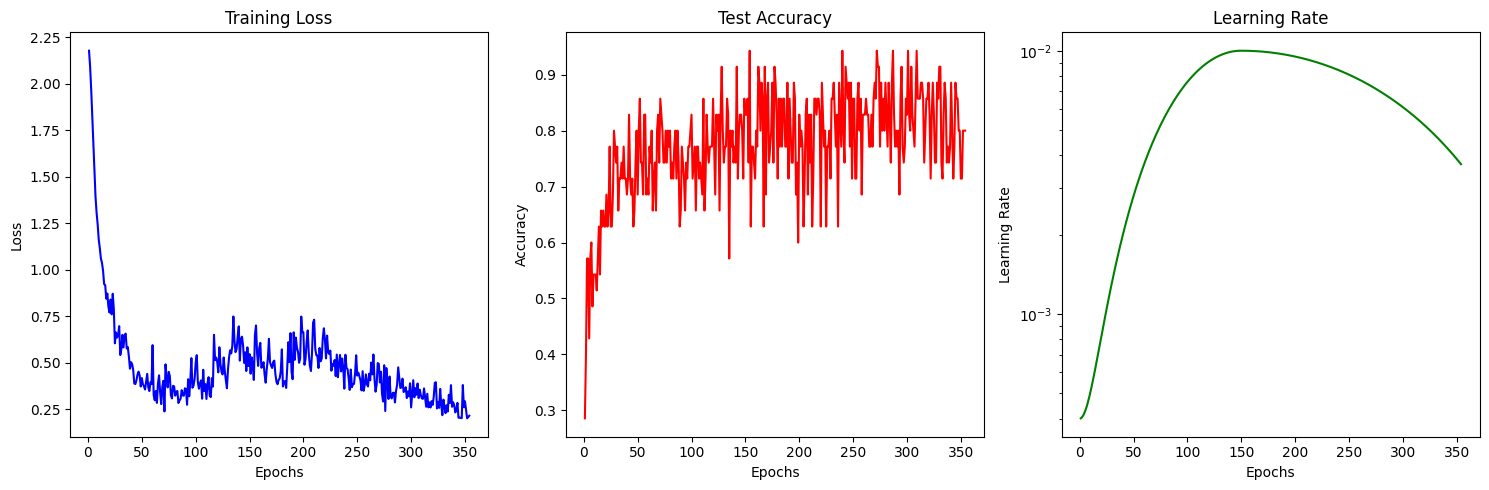

In [ ]:
def plot_training_results(train_losses, test_accuracies, learning_rates):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(15, 5))

    # Plot training loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Plot test accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, test_accuracies, 'r-')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot learning rate
    plt.subplot(1, 3, 3)
    plt.plot(epochs, learning_rates, 'g-')
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()
plot_training_results(train_losses, test_accuracies, learning_rates)

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

final_accuracy = correct / total
print(f'Final Test Accuracy: {final_accuracy:.4f}')

Final Test Accuracy: 0.9429


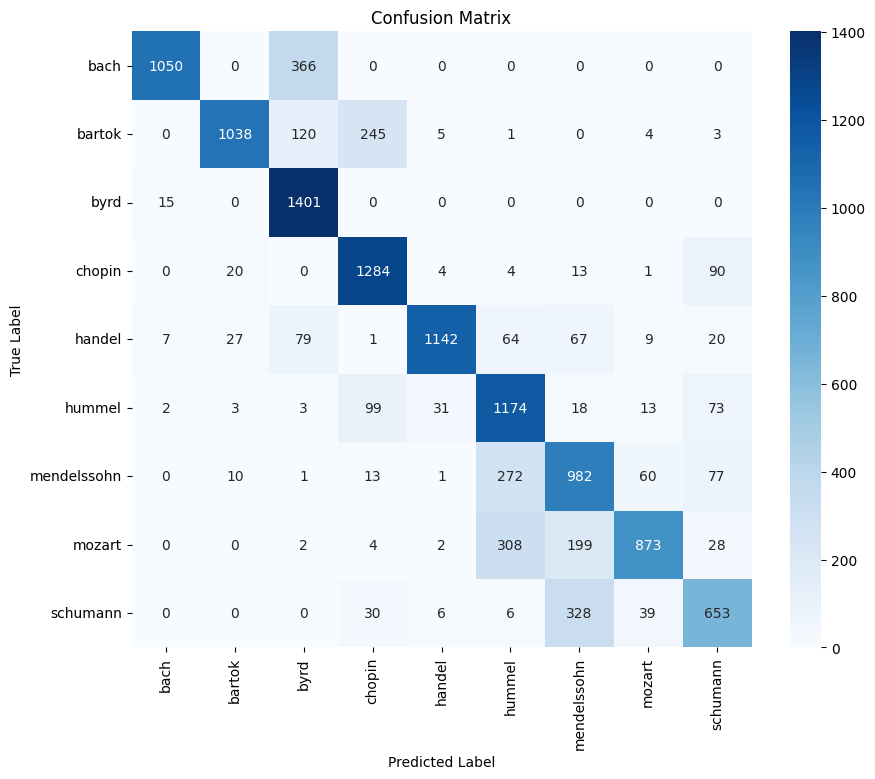

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
plot_confusion_matrix(all_true, all_preds, le.classes_)

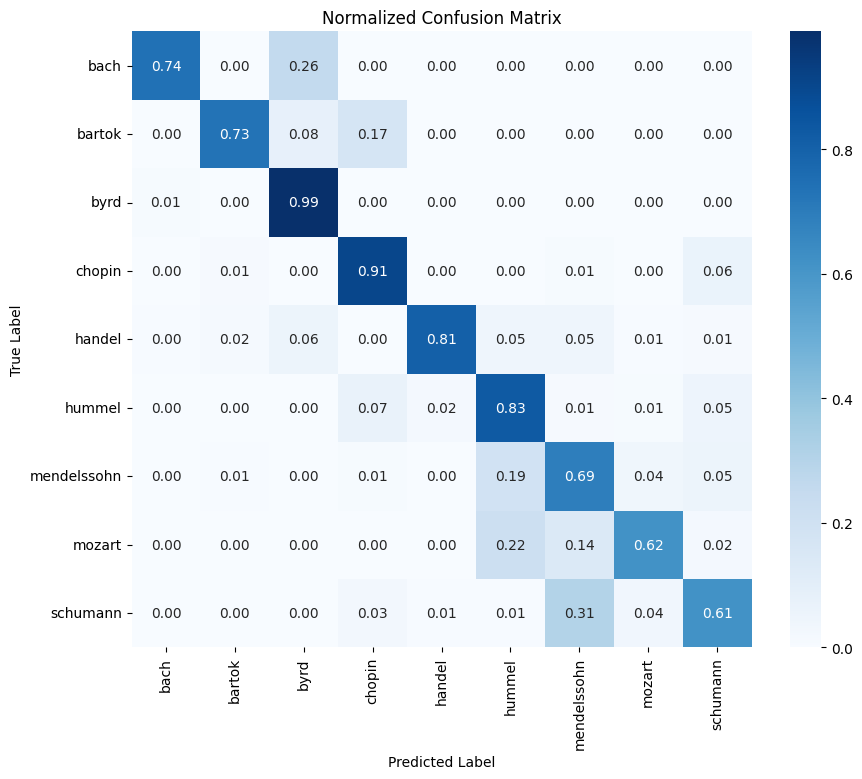

In [ ]:
def plot_normalized_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_normalized_confusion_matrix(all_true, all_preds, le.classes_)

# Peak Result vs. Final Result

Best Model Test Accuracy: 0.9429
Final Model Test Accuracy: 0.8000


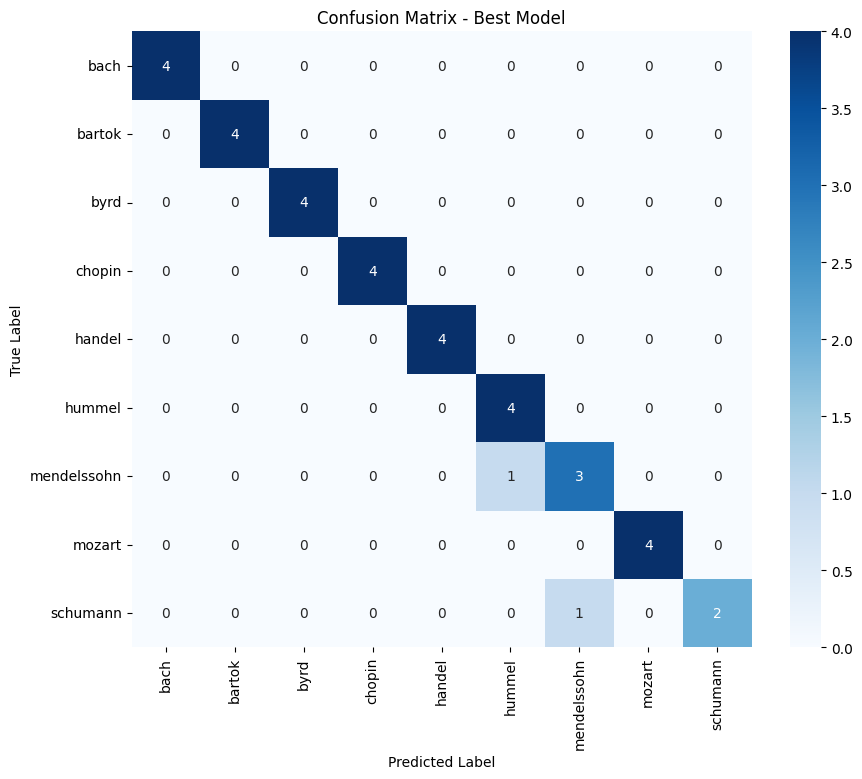

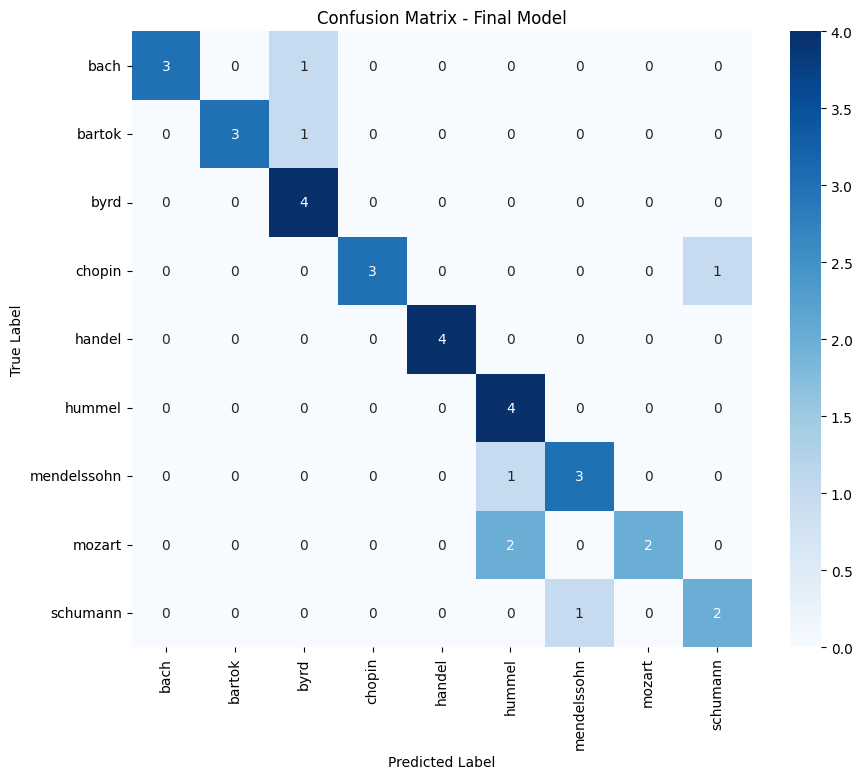


Classification Report - Best Model
              precision    recall  f1-score   support

        bach       1.00      1.00      1.00         4
      bartok       1.00      1.00      1.00         4
        byrd       1.00      1.00      1.00         4
      chopin       1.00      1.00      1.00         4
      handel       1.00      1.00      1.00         4
      hummel       0.80      1.00      0.89         4
 mendelssohn       0.75      0.75      0.75         4
      mozart       1.00      1.00      1.00         4
    schumann       1.00      0.67      0.80         3

    accuracy                           0.94        35
   macro avg       0.95      0.94      0.94        35
weighted avg       0.95      0.94      0.94        35


Classification Report - Final Model
              precision    recall  f1-score   support

        bach       1.00      0.75      0.86         4
      bartok       1.00      0.75      0.86         4
        byrd       0.67      1.00      0.80         4
     

In [ ]:
def evaluate_model(model, test_loader, model_name):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    accuracy = correct / total
    print(f'{model_name} Test Accuracy: {accuracy:.4f}')

    return np.array(all_true), np.array(all_preds)

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def print_classification_report(y_true, y_pred, class_names, title):
    print(f"\n{title}")
    print(classification_report(y_true, y_pred, target_names=class_names))

# peak model
best_model = ComposerClassifier(input_size, hidden_size, num_classes)
best_model.load_state_dict(torch.load('new_best_model.pth'))
y_true_best, y_pred_best = evaluate_model(best_model, test_loader, "Best Model")

# Final Model
y_true_final, y_pred_final = evaluate_model(model, test_loader, "Final Model")


plot_confusion_matrix(y_true_best, y_pred_best, le.classes_, "Confusion Matrix - Best Model")
plot_confusion_matrix(y_true_final, y_pred_final, le.classes_, "Confusion Matrix - Final Model")

print_classification_report(y_true_best, y_pred_best, le.classes_, "Classification Report - Best Model")
print_classification_report(y_true_final, y_pred_final, le.classes_, "Classification Report - Final Model")